<a href="https://colab.research.google.com/github/yilmajung/KM4D_v0/blob/main/ksp_pilot_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/yilmajung/KM4D_v0/blob/main/ksp_pilot_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KSP Knowledge Extraction - Chapter-Level Classification & Policy Extraction

**Pipeline Overview:**
For each chapter/sub-chapter of a KSP report, this notebook performs:
1. **Taxonomy Classification** — tags sectors & keywords from the development cooperation taxonomy
2. **Knowledge Type** — classifies as one of 4 knowledge types
3. **Korean Policy Extraction** — extracts policy_name, year_initiated, organization, challenge_addressed, policy_instruments, sector
4. **Theory Linking** — matches related theories from development economics textbooks (via RAG)

**Key Design:**
- Chapters are read directly (no KSP chunking/RAG needed)
- Textbook RAG is kept for theory linking
- Single combined LLM call per chapter
- Full taxonomy embedded in prompt (~3K tokens)

## Section 1: Setup & Installation

In [1]:
# Install required packages
!pip install -q pymupdf pdfplumber sentence-transformers chromadb anthropic pandas numpy scikit-learn matplotlib seaborn plotly networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.9/405.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/1

In [2]:
# Mount Google Drive for file persistence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create project directory in Google Drive
import os
project_dir = '/content/drive/MyDrive/KM4D_v0'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/data/raw/ksp_reports', exist_ok=True)
os.makedirs(f'{project_dir}/data/raw/textbooks', exist_ok=True)
os.makedirs(f'{project_dir}/data/processed', exist_ok=True)
os.makedirs(f'{project_dir}/data/results', exist_ok=True)
os.makedirs(f'{project_dir}/vector_db', exist_ok=True)

print('Project directory created in Google Drive')
print(f'  Location: {project_dir}')

Project directory created in Google Drive
  Location: /content/drive/MyDrive/KM4D_v0


## Section 2: Configuration

In [4]:
import os
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
import json

@dataclass
class Config:
    """Central configuration for the chapter-level analysis pipeline."""

    # Directories
    project_dir: str = project_dir
    ksp_dir: str = f'{project_dir}/data/raw/ksp_reports'
    textbook_dir: str = f'{project_dir}/data/raw/textbooks'
    processed_dir: str = f'{project_dir}/data/processed'
    results_dir: str = f'{project_dir}/data/results'
    vector_db_dir: str = f'{project_dir}/vector_db'

    # Textbook chunking parameters
    textbook_chunk_size: int = 768
    chunk_overlap: int = 50

    # Embedding model
    embedding_model: str = 'sentence-transformers/all-MiniLM-L6-v2'

    # LLM API
    llm_model: str = 'claude-sonnet-4-20250514'
    temperature: float = 0.1
    max_tokens: int = 4096

    # Retrieval parameters (textbook only)
    textbook_top_k: int = 3

    # Textbook collection
    textbook_collection: str = 'textbooks_pilot'

config = Config()
print('Config initialized')

Config initialized


In [5]:
# API Key Setup
from google.colab import userdata

try:
    ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')
    print('API key loaded from Colab secrets')
except:
    print('No API key found in Colab secrets')
    ANTHROPIC_API_KEY = input('Or enter API key here: ')

API key loaded from Colab secrets


## Section 3: Taxonomy Reference & Knowledge Types

In [6]:
# Full 6-sector, 4-level taxonomy from the Development Cooperation Taxonomy
# Structure: Sector -> Sub-sector L1 -> Sub-sector L2 -> Keywords

TAXONOMY = {
    '(1) Economic Policy': {
        'Macroeconomic Policy & Stability': {
            'Fiscal Policy': [
                'Public Finance Management (PFM)',
                'Tax Policy & Administration',
                'Public Expenditure Management',
                'Sovereign Debt Management',
                'Domestic Revenue Mobilization'
            ],
            'Monetary & Financial Policy': [
                'Financial Sector Development',
                'Monetary Policy & Central Banking',
                'Financial Stability & Regulation',
                'Financial Inclusion'
            ]
        },
        'Inclusive & Sustainable Growth': {
            'Growth Diagnostics & Strategy': [
                'Economic Growth Strategy',
                'Structural Reform',
                'Productivity Analysis',
                'Green Growth'
            ],
            'Poverty & Inequality': [
                'Poverty Reduction Strategy',
                'Inequality Analysis (Income, Wealth)',
                'Social Protection Systems'
            ]
        },
        'Investment & Private Sector Dev.': {
            'Investment Climate': [
                'Investment Policy & Promotion',
                'Business Environment Reform',
                'Competition Policy',
                'Corporate Governance'
            ],
            'Private Sector Support': [
                'Small & Medium Enterprise (SME) Dev.',
                'Foreign Direct Investment (FDI)',
                'Public-Private Partnerships (PPPs)',
                'Entrepreneurship'
            ]
        }
    },
    '(2) Social Services': {
        'Education': {
            'Education Policy & Systems': [
                'Education Policy & Administration',
                'Education Sector Planning',
                'Teacher Training',
                'Educational Facilities'
            ],
            'Levels of Education': [
                'Early Childhood Education',
                'Primary Education',
                'Secondary Education',
                'Higher Education',
                'Vocational Training (TVET)',
                'Adult Education & Lifelong Learning'
            ]
        },
        'Health': {
            'Health Policy & Systems': [
                'Health Policy & Administration',
                'Health Systems Strengthening',
                'Health Financing & Insurance',
                'Health Workforce Development',
                'Digital Health'
            ],
            'Health Services & Outcomes': [
                'Basic Health Care',
                'Maternal & Child Health',
                'Infectious Disease Control (HIV/AIDS, TB)',
                'Non-Communicable Diseases (NCDs)',
                'Mental Health',
                'Pandemic Preparedness & Response'
            ]
        },
        'Social Protection & Inclusion': {
            'Social Welfare Services': [
                'Social/Welfare Services',
                'Child Protection',
                'Services for the Elderly & Disabled'
            ]
        },
        'Cross-Cutting Social Issues': {
            'Gender Equality & Empowerment': [
                'Gender Equality',
                "Women's Economic Empowerment",
                'Ending Violence Against Women & Girls',
                'Youth Development & Employment',
                'Food Security & Nutrition'
            ]
        }
    },
    '(3) Digital Innovation': {
        'Digital Policy & Governance': {
            'Digital Strategy & Regulation': [
                'National Digital Strategy',
                'Data Governance & Privacy',
                'Cybersecurity Policy',
                'AI Governance & Ethics',
                'Digital Taxation'
            ]
        },
        'Digital Infrastructure': {
            'Connectivity': [
                'Universal Connectivity',
                'Broadband Infrastructure',
                'Mobile Networks (5G)'
            ],
            'Core Digital Systems': [
                'Digital Public Infrastructure (DPI)',
                'Digital Identity Systems',
                'Digital Payment Systems'
            ]
        },
        'Digital Transformation': {
            'Digital Inclusion & Skills': [
                'Digital Literacy & Skills',
                'Addressing the Digital Divide',
                'Gender and Digital Inclusion'
            ],
            'Digital Economy & Services': [
                'E-Commerce',
                'Digital Financial Services (FinTech)',
                'E-Government Services',
                'Digital Entrepreneurship',
                'Platform Economy'
            ]
        },
        'Emerging Technologies': {
            'Technology Adoption': [
                'Artificial Intelligence (AI)',
                'Internet of Things (IoT)',
                'Blockchain',
                'Big Data Analytics'
            ],
            'Digital Public Goods': [
                'Open Source Software & Data',
                'Open Standards'
            ]
        }
    },
    '(4) Production & Trade': {
        'Agriculture, Forestry & Fisheries': {
            'Agricultural Development': [
                'Agricultural Policy & Administration',
                'Agricultural Research & Extension',
                'Sustainable Agriculture',
                'Agricultural Value Chains',
                'Smallholder Farmer Support'
            ],
            'Forestry & Fisheries': [
                'Forestry Development',
                'Sustainable Forest Management',
                'Fisheries Development',
                'Aquaculture'
            ]
        },
        'Industry & Services': {
            'Industrial Development': [
                'Industrial Policy',
                'Manufacturing',
                'Agro-industry',
                'Mineral Resources & Mining'
            ],
            'Services Sector Development': [
                'Tourism Development',
                'Business & Other Services'
            ]
        },
        'Trade Policy & Facilitation': {
            'Trade Policy & Regulation': [
                'Trade Policy & Regulations',
                'WTO Accession & Compliance',
                'Regional Trade Agreements'
            ],
            'Trade Facilitation': [
                'Customs Modernization',
                'Border Management',
                'Aid for Trade',
                'Global Value Chains (GVCs)'
            ]
        }
    },
    '(5) Infrastructure': {
        'Infrastructure Policy & Finance': {
            'Infrastructure Governance': [
                'Infrastructure Policy & Planning',
                'Infrastructure Governance',
                'Public Investment Management'
            ],
            'Infrastructure Finance': [
                'Infrastructure Financing',
                'Private Investment in Infrastructure',
                'Blended Finance'
            ]
        },
        'Transport': {
            'Transport Policy & Planning': [
                'Transport Policy & Administration',
                'Urban Transport',
                'Rural Transport'
            ],
            'Transport Modalities': [
                'Road Transport',
                'Rail Transport',
                'Water Transport (Ports, Inland)',
                'Air Transport'
            ]
        },
        'Water & Sanitation': {
            'Water & Sanitation Policy': [
                'Water & Sanitation Policy',
                'Integrated Water Resource Management'
            ],
            'Water & Sanitation Services': [
                'Water Supply Systems',
                'Sanitation & Hygiene (WASH)',
                'Wastewater Management'
            ]
        },
        'Urban & Rural Development': {
            'Urban Development': [
                'Urban Development & Management',
                'Affordable Housing'
            ],
            'Rural Development': [
                'Rural Development'
            ]
        }
    },
    '(6) Energy & Environment': {
        'Environmental Policy & Management': {
            'Environmental Governance': [
                'Environmental Policy & Admin. Management',
                'Biosafety & Biodiversity',
                'Water Resources Protection',
                'Circular Economy'
            ]
        },
        'Climate Change': {
            'Climate Change Mitigation': [
                'Renewable Energy Generation',
                'Energy Efficiency',
                'Greenhouse Gas (GHG) Reduction',
                'Carbon Markets & Pricing'
            ],
            'Climate Change Adaptation': [
                'Climate Adaptation Strategies',
                'Disaster Risk Reduction (DRR)',
                'Climate Resilient Infrastructure',
                'Climate Finance'
            ]
        },
        'Energy': {
            'Energy Policy & Access': [
                'Energy Policy & Planning',
                'Universal Energy Access',
                'Just Energy Transition (JET)',
                'Energy Sector Reform & Regulation'
            ],
            'Energy Generation & Supply': [
                'Renewable Energy (Solar, Wind, Hydro)',
                'Non-Renewable Energy (Fossil Fuels)',
                'Energy Transmission & Distribution'
            ]
        }
    }
}

# Knowledge types for classifying chapter content
KNOWLEDGE_TYPES = [
    'Policy Entrepreneurship (leadership)',
    'Policy Implementation & Coordinating Mechanism',
    'Organizational/Individual Capacity',
    'Technical Know-how'
]


def taxonomy_to_prompt_string() -> str:
    """Convert TAXONOMY dict to a readable string for LLM prompts."""
    lines = []
    for sector, l1_dict in TAXONOMY.items():
        lines.append(f'\n{sector}')
        for l1, l2_dict in l1_dict.items():
            lines.append(f'  {l1}')
            for l2, keywords in l2_dict.items():
                lines.append(f'    {l2}')
                for kw in keywords:
                    lines.append(f'      - {kw}')
    return '\n'.join(lines)


def get_all_valid_keywords() -> set:
    """Get flat set of all valid keywords for validation."""
    keywords = set()
    for sector, l1_dict in TAXONOMY.items():
        for l1, l2_dict in l1_dict.items():
            for l2, kw_list in l2_dict.items():
                keywords.update(kw_list)
    return keywords


all_keywords = get_all_valid_keywords()
print(f'Taxonomy loaded: {len(TAXONOMY)} sectors, {len(all_keywords)} keywords')
print(f'Knowledge types: {len(KNOWLEDGE_TYPES)}')
print()
for sector in TAXONOMY:
    n_kw = sum(len(kw) for l1 in TAXONOMY[sector].values() for kw in l1.values())
    print(f'  {sector}: {n_kw} keywords')

Taxonomy loaded: 6 sectors, 140 keywords
Knowledge types: 4

  (1) Economic Policy: 24 keywords
  (2) Social Services: 29 keywords
  (3) Digital Innovation: 25 keywords
  (4) Production & Trade: 22 keywords
  (5) Infrastructure: 21 keywords
  (6) Energy & Environment: 19 keywords


## Section 4: Chapter Extraction from KSP Reports (TOC Parsing)

Extracts chapters by parsing the Table of Contents pages:
- Detects dot-leader patterns (`.`, `…`, `·`, `∙`) to find TOC pages
- Filters out figure/table list pages
- Handles multi-line titles and page number resolution
- Truncates at page wrap-around to exclude appendix table/figure lists

In [7]:
import fitz  # PyMuPDF
import re
from pathlib import Path
from collections import defaultdict, Counter


class TOCChapterExtractor:
    """Extract chapters from KSP reports by parsing the Table of Contents pages.

    Approach:
    - Find TOC pages by detecting dot-leader patterns (., …, ·, ∙)
    - Filter out figure/table list pages
    - Parse TOC entries with multi-line title support
    - Resolve TOC page numbers to actual PDF page indices
    - Truncate at page wrap-around (catches table/figure list residue)
    - Extract text for each chapter by page range

    Returns dicts compatible with the downstream ChapterAnalyzer pipeline.
    """

    # 2+ repeated dot-leader chars (covers ., …, ·, ∙ across all report styles)
    DOT_LEADER_RE = re.compile(r'[.…·∙\u00B7\u2026\u2219]{2,}')
    PAGE_NUM_RE = re.compile(r'[.…·∙\u00B7\u2026\u2219\s]*(\d{1,3})\s*$')
    LIST_HEADER_RE = re.compile(
        r'List\s+of\s+(Tables?|Figures?|Pictures?|Exhibits?)', re.IGNORECASE
    )

    def __init__(self, pdf_path: str):
        self.pdf_path = pdf_path
        self.filename = Path(pdf_path).stem
        self.doc = fitz.open(pdf_path)
        self.metadata = self._extract_metadata()

    def close(self):
        self.doc.close()

    def _extract_metadata(self) -> Dict:
        """Extract metadata from filename (YYYY_CCC_Title.pdf)."""
        pattern = r'(\d{4})_([A-Z]{3})_(.+)'
        match = re.match(pattern, self.filename)
        if match:
            return {
                'year': match.group(1),
                'country': match.group(2),
                'title': match.group(3).replace('_', ' '),
                'filename': self.filename
            }
        return {'filename': self.filename}

    def _find_toc_pages(self) -> List[int]:
        """Find content TOC pages, excluding figure/table list pages."""
        candidates = []
        max_page = min(len(self.doc), max(20, int(len(self.doc) * 0.15)))

        for pg_idx in range(max_page):
            text = self.doc[pg_idx].get_text()
            lines = text.split('\n')
            dot_count = sum(
                1 for l in lines
                if self.DOT_LEADER_RE.search(l) and self.PAGE_NUM_RE.search(l)
            )
            if dot_count >= 3:
                is_list = bool(self.LIST_HEADER_RE.search(text[:500]))
                if not is_list:
                    fig_entries = sum(
                        1 for l in lines
                        if self.DOT_LEADER_RE.search(l) and self.PAGE_NUM_RE.search(l)
                        and re.match(
                            r'^\s*(\[?\s*(Figure|Table|Picture|Exhibit)\b|<\s*(Table|Figure))',
                            l.strip(), re.IGNORECASE
                        )
                    )
                    if dot_count > 0 and fig_entries / dot_count > 0.5:
                        is_list = True
                candidates.append((pg_idx, is_list))

        # Check adjacent pages for continuation
        known = {pg for pg, _ in candidates}
        for pg, _ in list(candidates):
            for adj in [pg - 1, pg + 1]:
                if 0 <= adj < max_page and adj not in known:
                    text = self.doc[adj].get_text()
                    lines = text.split('\n')
                    dc = sum(
                        1 for l in lines
                        if self.DOT_LEADER_RE.search(l) and self.PAGE_NUM_RE.search(l)
                    )
                    if dc >= 2:
                        is_list = bool(self.LIST_HEADER_RE.search(text[:500]))
                        if not is_list:
                            fe = sum(
                                1 for l in lines
                                if self.DOT_LEADER_RE.search(l) and self.PAGE_NUM_RE.search(l)
                                and re.match(
                                    r'^\s*(\[?\s*(Figure|Table|Picture)\b|<\s*(Table|Figure))',
                                    l.strip(), re.IGNORECASE
                                )
                            )
                            if dc > 0 and fe / dc > 0.5:
                                is_list = True
                        candidates.append((adj, is_list))
                        known.add(adj)

        candidates.sort()
        # Return only content pages; stop at first list page
        content_pages = []
        for pg, is_list in candidates:
            if is_list:
                break
            content_pages.append(pg)
        return content_pages

    def _parse_toc_entries(self, toc_pages: List[int]) -> List[Dict]:
        """Parse TOC entries from identified TOC pages, handling multi-line titles."""
        entries = []

        for pg_idx in toc_pages:
            text = self.doc[pg_idx].get_text()
            lines = text.split('\n')

            i = 0
            while i < len(lines):
                stripped = lines[i].strip()

                # Skip empty lines, headers
                if not stripped or stripped.lower() in ('contents', 'table of contents'):
                    i += 1
                    continue
                if re.match(r'^Chapter\s+\d+\s*$', stripped, re.IGNORECASE):
                    i += 1
                    continue

                # --- Line has dot leaders ---
                if self.DOT_LEADER_RE.search(stripped):
                    pm = self.PAGE_NUM_RE.search(stripped)
                    if pm:
                        title = self.DOT_LEADER_RE.split(stripped)[0].strip()
                        if not title or len(title) < 3:
                            i += 1
                            continue
                        # Skip table/figure entries
                        if re.match(
                            r'^(<\s*(Table|Figure)|\[?\s*(Figure|Table|Picture))',
                            title, re.IGNORECASE
                        ):
                            i += 1
                            continue
                        title = re.sub(r'\s+', ' ', title).rstrip('.…·∙ ')
                        entries.append({
                            'title': title,
                            'page_num': int(pm.group(1)),
                            'level': self._detect_level(title)
                        })
                        i += 1
                        continue

                    # Dots but no page number — look ahead
                    title_so_far = self.DOT_LEADER_RE.split(stripped)[0].strip()
                    found = False
                    for j in range(i + 1, min(i + 3, len(lines))):
                        ns = lines[j].strip()
                        if not ns:
                            continue
                        pm = self.PAGE_NUM_RE.search(ns)
                        if pm:
                            tp = self.DOT_LEADER_RE.split(ns)[0].strip()
                            combined = (title_so_far + ' ' + tp).strip() if tp else title_so_far
                            combined = re.sub(r'\s+', ' ', combined).rstrip('.…·∙ ')
                            if len(combined) >= 3:
                                entries.append({
                                    'title': combined,
                                    'page_num': int(pm.group(1)),
                                    'level': self._detect_level(combined)
                                })
                            i = j + 1
                            found = True
                            break
                        break
                    if not found:
                        i += 1
                    continue

                # --- No dots: check for multi-line title ---
                found = False
                combined = stripped
                for j in range(i + 1, min(i + 4, len(lines))):
                    ns = lines[j].strip()
                    if not ns:
                        continue
                    if self.DOT_LEADER_RE.search(ns):
                        pm = self.PAGE_NUM_RE.search(ns)
                        if pm:
                            tp = self.DOT_LEADER_RE.split(ns)[0].strip()
                            # Don't concatenate if dotted line is a standalone numbered entry
                            if re.match(r'^\d+[\.\)]\s', tp) or re.match(r'^[A-Z]\.\s', tp):
                                break
                            if tp:
                                combined += ' ' + tp
                            combined = re.sub(r'\s+', ' ', combined).rstrip('.…·∙ ')
                            if len(combined) >= 3:
                                entries.append({
                                    'title': combined,
                                    'page_num': int(pm.group(1)),
                                    'level': self._detect_level(combined)
                                })
                            i = j + 1
                            found = True
                            break
                    # If next line starts a new numbered entry, stop
                    if re.match(r'^\d+[\.\)]\s', ns) or re.match(r'^[A-Z]\.\s', ns):
                        break
                    combined += ' ' + ns

                if not found:
                    i += 1

        return entries

    def _detect_level(self, title: str) -> int:
        """Detect hierarchy level from title numbering pattern."""
        t = title.strip()
        if re.match(r'^Chapter\s+\d', t, re.IGNORECASE):
            return 0
        if re.match(r'^\d{1,2}\.\s', t):
            return 1
        if re.match(r'^[A-Z]\.\s', t):
            return 1
        if re.match(r'^\d+\.\d+\.?\s', t):
            return 2
        if re.match(r'^\d+\)\s', t):
            return 2
        if re.match(r'^\d+\.\d+\.\d+', t):
            return 3
        return 1

    def _resolve_page_numbers(self, entries: List[Dict]) -> List[Dict]:
        """Resolve TOC page numbers to PDF page indices; truncate at page wrap-around."""
        if not entries:
            return entries

        # Detect page offset by sampling entries
        offsets = []
        indices = (
            list(range(min(5, len(entries))))
            + list(range(len(entries) // 2, min(len(entries) // 2 + 3, len(entries))))
        )
        for idx in indices:
            entry = entries[idx]
            st = re.sub(r'^\d+[\.\)]\s*', '', entry['title'])
            st = re.sub(r'^[A-Z]\.\s*', '', st)
            st = re.sub(r'^\d+\.\d+\.?\s*', '', st)
            if len(st) < 5:
                continue
            search = st[:40].strip()
            exp = entry['page_num']
            for pg in range(max(0, exp - 10), min(len(self.doc), exp + 10)):
                if search in self.doc[pg].get_text():
                    offsets.append(pg - exp)
                    break

        best = Counter(offsets).most_common(1)[0][0] if offsets else 0

        for e in entries:
            e['pdf_page'] = max(0, min(e['page_num'] + best, len(self.doc) - 1))

        # Truncate at page wrap-around
        mx = entries[0]['pdf_page']
        for i in range(1, len(entries)):
            if entries[i]['pdf_page'] < mx - 5:
                return entries[:i]
            mx = max(mx, entries[i]['pdf_page'])

        return entries

    def extract_chapters(self, level_filter: Optional[int] = 1) -> List[Dict]:
        """Extract chapters from PDF using TOC parsing.

        Args:
            level_filter: Max level to include (1 = chapters + sections, 2 = include
                         subsections). None = all levels.

        Returns:
            List of dicts with keys: chapter_title, chapter_level, content,
            page_start, page_end, content_length.
        """
        toc_pages = self._find_toc_pages()
        if not toc_pages:
            print(f'  WARNING: No TOC pages found in {self.filename}')
            return []

        print(f'  TOC pages (PDF): {[p + 1 for p in toc_pages]}')

        entries = self._parse_toc_entries(toc_pages)
        if not entries:
            print(f'  WARNING: No TOC entries parsed')
            return []

        print(f'  Parsed {len(entries)} TOC entries')

        if level_filter is not None:
            entries = [e for e in entries if e['level'] <= level_filter]
            print(f'  After level filter (≤{level_filter}): {len(entries)}')

        entries = self._resolve_page_numbers(entries)
        print(f'  After page resolution: {len(entries)}')

        # Build chapter dicts with text content
        chapters = []
        for i, entry in enumerate(entries):
            ps = entry['pdf_page']
            pe = entries[i + 1]['pdf_page'] if i + 1 < len(entries) else len(self.doc)

            if pe <= ps:
                continue  # Skip 0-content entries (parent headers)

            content = '\n'.join(
                self.doc[pg].get_text()
                for pg in range(ps, pe)
                if 0 <= pg < len(self.doc)
            )

            chapters.append({
                'chapter_title': entry['title'],
                'chapter_level': entry['level'],
                'content': content,
                'page_start': ps + 1,  # 1-indexed for display
                'page_end': pe,
                'content_length': len(content)
            })

        return chapters

    def get_summary(self) -> Dict:
        """Get a summary of the extracted chapters."""
        chapters = self.extract_chapters()
        return {
            'filename': self.filename,
            'metadata': self.metadata,
            'num_chapters': len(chapters),
            'chapters': [
                {
                    'title': ch['chapter_title'],
                    'level': ch['chapter_level'],
                    'pages': f"{ch['page_start']}-{ch['page_end']}",
                    'chars': ch['content_length']
                }
                for ch in chapters
            ]
        }


print('TOCChapterExtractor class defined')

TOCChapterExtractor class defined


In [8]:
# Test TOC-based chapter extraction on one report
ksp_pdfs = list(Path(config.ksp_dir).glob('*.pdf'))
if ksp_pdfs:
    test_pdf = str(ksp_pdfs[0])
    print(f'Testing on: {Path(test_pdf).name}')
    print()

    extractor = TOCChapterExtractor(test_pdf)
    print(f'Metadata: {extractor.metadata}')

    chapters = extractor.extract_chapters(level_filter=1)
    print(f'\nExtracted {len(chapters)} chapters/sections')
    print()
    for i, ch in enumerate(chapters[:15]):
        level_marker = '  ' * ch['chapter_level']
        print(f"{level_marker}[L{ch['chapter_level']}] {ch['chapter_title'][:80]}")
        print(f"{level_marker}     Pages {ch['page_start']}-{ch['page_end']}, {ch['content_length']:,} chars")
    if len(chapters) > 15:
        print(f'  ... and {len(chapters) - 15} more')

    extractor.close()
else:
    print(f'No KSP reports found in: {config.ksp_dir}')
    print('Please upload PDF reports to this directory')

Testing on: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E.pdf

Metadata: {'year': '2009', 'country': 'VNM', 'title': 'Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy E', 'filename': '2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E'}
  TOC pages (PDF): [17, 18, 19]
  Parsed 64 TOC entries
  After level filter (≤1): 64
  After page resolution: 64

Extracted 52 chapters/sections

  [L1] 1. Assessment of Vietnam’s Economic Growth Performance
       Pages 31-31, 1,530 chars
  [L1] 2. Projection of GDP Growth
       Pages 32-33, 4,046 chars
  [L1] 3. Suggested Policy Priorities for Strengthening and Sustaining Vietna
       Pages 34-34, 2,150 chars
  [L1] 1. Introduction
       Pages 35-35, 2,058 chars
  [L1] 2. Overview and Assessment of the Vietnamese Economic Development: 1986-2009
       Pages 36-85, 115,781 chars
  [L1] 3. Evaluation of Vietnam’s Econ

## Section 5: Textbook Vector Store (for Theory Linking)

In [9]:
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
from tqdm import tqdm
import numpy as np


class VectorStore:
    """Manage embeddings and ChromaDB vector database for textbooks."""

    def __init__(self, collection_name: str, persist_directory: str = None):
        self.collection_name = collection_name

        # Initialize embedding model
        print(f'Loading embedding model: {config.embedding_model}...')
        self.embedding_model = SentenceTransformer(config.embedding_model)
        print('Embedding model loaded')

        # Initialize ChromaDB with persistence
        if persist_directory is None:
            persist_directory = config.vector_db_dir

        self.client = chromadb.Client(Settings(
            persist_directory=persist_directory,
            anonymized_telemetry=False
        ))

        try:
            self.collection = self.client.get_collection(name=collection_name)
            print(f'Loaded existing collection: {collection_name}')
        except:
            self.collection = self.client.create_collection(
                name=collection_name,
                metadata={'description': f'Collection for {collection_name}'}
            )
            print(f'Created new collection: {collection_name}')

    def add_documents(self, chunks: List[Dict], batch_size: int = 32):
        """Add document chunks to vector database."""
        documents = [chunk['text'] for chunk in chunks]
        metadatas = [chunk['metadata'] for chunk in chunks]
        ids = [chunk['metadata']['chunk_id'] for chunk in chunks]

        print(f'Adding {len(documents)} documents to {self.collection_name}...')

        all_embeddings = []
        for i in tqdm(range(0, len(documents), batch_size), desc='Embedding'):
            batch_docs = documents[i:i+batch_size]
            embeddings = self.embedding_model.encode(
                batch_docs, show_progress_bar=False, convert_to_numpy=True
            ).tolist()
            all_embeddings.extend(embeddings)

        for i in tqdm(range(0, len(documents), batch_size), desc='Storing'):
            batch_end = min(i + batch_size, len(documents))
            self.collection.add(
                documents=documents[i:batch_end],
                embeddings=all_embeddings[i:batch_end],
                metadatas=metadatas[i:batch_end],
                ids=ids[i:batch_end]
            )

        print(f'Added {len(documents)} chunks to collection')

    def search(self, query: str, n_results: int = 5, filter_dict: Dict = None) -> Dict:
        """Search for relevant chunks."""
        query_embedding = self.embedding_model.encode([query])[0].tolist()
        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=n_results,
            where=filter_dict
        )
        return results

    def get_stats(self) -> Dict:
        """Get collection statistics."""
        return {
            'collection_name': self.collection_name,
            'total_chunks': self.collection.count()
        }


print('VectorStore class defined')

VectorStore class defined


In [10]:
# Initialize textbook vector store
print('\n' + '='*60)
print('INITIALIZING TEXTBOOK VECTOR DATABASE')
print('='*60)

textbook_store = VectorStore(
    collection_name=config.textbook_collection,
    persist_directory=config.vector_db_dir
)

print(f'\n Textbook store initialized')
print(f'  ChromaDB persisted to: {config.vector_db_dir}')
print(f'  Current stats: {textbook_store.get_stats()}')


INITIALIZING TEXTBOOK VECTOR DATABASE
Loading embedding model: sentence-transformers/all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model loaded
Created new collection: textbooks_pilot

 Textbook store initialized
  ChromaDB persisted to: /content/drive/MyDrive/KM4D_v0/vector_db
  Current stats: {'collection_name': 'textbooks_pilot', 'total_chunks': 0}


In [11]:
!pip install -q langchain langchain-text-splitters

In [12]:
# Index textbooks (run once; skip if already indexed)
from langchain_text_splitters import RecursiveCharacterTextSplitter


def process_and_index_textbooks():
    """Process textbooks and add to vector database."""
    textbook_dir = Path(config.textbook_dir)
    pdf_files = list(textbook_dir.glob('*.pdf'))

    print(f'\nFound {len(pdf_files)} textbooks')

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=config.textbook_chunk_size,
        chunk_overlap=config.chunk_overlap,
        separators=['\n\n', '\n', '. ', ' ', ''],
        length_function=len
    )

    all_chunks = []

    for pdf_path in pdf_files:
        print(f'\nProcessing: {pdf_path.name}')

        # Extract text with sections via PyMuPDF
        doc = fitz.open(str(pdf_path))
        sections = []
        current_section = {'title': 'Introduction', 'content': '', 'page': 1}

        for page_num, page in enumerate(doc, 1):
            blocks = page.get_text('dict')['blocks']
            for block in blocks:
                if 'lines' not in block:
                    continue
                for line in block['lines']:
                    text = ''
                    font_size = 0
                    for span in line['spans']:
                        text += span['text']
                        font_size = max(font_size, span['size'])
                    text = text.strip()
                    if not text:
                        continue
                    if font_size > 12 and len(text) < 100:
                        if current_section['content'].strip():
                            sections.append(current_section)
                        current_section = {'title': text, 'content': '', 'page': page_num}
                    else:
                        current_section['content'] += text + '\n'

        if current_section['content'].strip():
            sections.append(current_section)
        doc.close()

        print(f'  Extracted {len(sections)} sections')

        # Chunk sections
        filename = pdf_path.stem
        metadata_base = {'source_type': 'textbook', 'filename': filename}

        for s_idx, section in enumerate(sections):
            sub_chunks = splitter.split_text(section['content'])
            for c_idx, chunk_text in enumerate(sub_chunks):
                all_chunks.append({
                    'text': chunk_text,
                    'metadata': {
                        **metadata_base,
                        'section_title': section['title'],
                        'section_index': s_idx,
                        'section_page': section['page'],
                        'chunk_index': c_idx,
                        'chunk_id': f'{filename}_s{s_idx}_c{c_idx}'
                    }
                })

        print(f'  Created {sum(1 for c in all_chunks if c["metadata"]["filename"] == filename)} chunks')

    # Add to vector database
    if all_chunks:
        textbook_store.add_documents(all_chunks)

        output_path = f'{config.processed_dir}/textbook_chunks.json'
        with open(output_path, 'w') as f:
            json.dump(all_chunks, f, indent=2)
        print(f'\n Saved processed chunks to: {output_path}')

    return all_chunks


# Check if textbooks are already indexed
stats = textbook_store.get_stats()
if stats['total_chunks'] > 0:
    print(f'\n Textbooks already indexed: {stats["total_chunks"]} chunks')
    print('  Skipping re-indexing. Delete collection to re-index.')
else:
    textbook_pdfs = list(Path(config.textbook_dir).glob('*.pdf'))
    if len(textbook_pdfs) == 0:
        print(f'\n No textbooks found in: {config.textbook_dir}')
        print('Please upload textbook PDFs to this directory')
    else:
        print(f'\n Found {len(textbook_pdfs)} textbooks. Indexing...')
        textbook_chunks = process_and_index_textbooks()
        print(f'\nTextbook Collection: {textbook_store.get_stats()}')


 Found 2 textbooks. Indexing...

Found 2 textbooks

Processing: Perkins et al_2012.pdf
  Extracted 87 sections
  Created 3273 chunks

Processing: Todoro_2012.pdf
  Extracted 281 sections
  Created 3921 chunks
Adding 7194 documents to textbooks_pilot...


Storing: 100%|██████████| 225/225 [00:13<00:00, 17.05it/s]


Added 7194 chunks to collection

 Saved processed chunks to: /content/drive/MyDrive/KM4D_v0/data/processed/textbook_chunks.json

Textbook Collection: {'collection_name': 'textbooks_pilot', 'total_chunks': 7194}


## Section 6: Process All KSP Reports (Chapter Extraction)

In [13]:
def extract_all_chapters() -> Dict[str, List[Dict]]:
    """Extract chapters from all KSP PDF reports using TOC parsing.

    Returns dict mapping report_id -> {'metadata': ..., 'chapters': [...]}.
    """
    ksp_dir = Path(config.ksp_dir)
    pdf_files = sorted(ksp_dir.glob('*.pdf'))

    print(f'Found {len(pdf_files)} KSP reports')

    all_reports = {}

    for pdf_path in pdf_files:
        print(f'\n{"="*60}')
        print(f'Processing: {pdf_path.name}')
        print('='*60)

        extractor = TOCChapterExtractor(str(pdf_path))
        chapters = extractor.extract_chapters(level_filter=1)

        report_id = extractor.filename
        all_reports[report_id] = {
            'metadata': extractor.metadata,
            'chapters': chapters
        }

        print(f'  Extracted {len(chapters)} chapters/sections')
        total_chars = sum(ch['content_length'] for ch in chapters)
        print(f'  Total text: {total_chars:,} characters')

        # Show chapter outline
        for ch in chapters[:15]:
            indent = '  ' * ch['chapter_level']
            print(f"  {indent}[L{ch['chapter_level']}] {ch['chapter_title'][:70]}  ({ch['content_length']:,} chars)")
        if len(chapters) > 15:
            print(f'  ... and {len(chapters) - 15} more')

        extractor.close()

    # Save chapter summaries
    summary = {}
    for report_id, data in all_reports.items():
        summary[report_id] = {
            'metadata': data['metadata'],
            'num_chapters': len(data['chapters']),
            'chapters': [
                {
                    'title': ch['chapter_title'],
                    'level': ch['chapter_level'],
                    'pages': f"{ch['page_start']}-{ch['page_end']}",
                    'chars': ch['content_length']
                }
                for ch in data['chapters']
            ]
        }

    summary_path = f'{config.processed_dir}/chapter_summaries.json'
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f'\n Chapter summaries saved to: {summary_path}')

    return all_reports


# Extract chapters from all reports
print('\n' + '='*60)
print('PHASE 1: CHAPTER EXTRACTION (TOC-based)')
print('='*60)

all_reports = extract_all_chapters()

total_chapters = sum(len(data['chapters']) for data in all_reports.values())
print(f'\n Total: {total_chapters} chapters/sections from {len(all_reports)} reports')


PHASE 1: CHAPTER EXTRACTION (TOC-based)
Found 4 KSP reports

Processing: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E.pdf
  TOC pages (PDF): [17, 18, 19]
  Parsed 64 TOC entries
  After level filter (≤1): 64
  After page resolution: 64
  Extracted 52 chapters/sections
  Total text: 985,989 characters
    [L1] 1. Assessment of Vietnam’s Economic Growth Performance  (1,530 chars)
    [L1] 2. Projection of GDP Growth  (4,046 chars)
    [L1] 3. Suggested Policy Priorities for Strengthening and Sustaining Vietna  (2,150 chars)
    [L1] 1. Introduction  (2,058 chars)
    [L1] 2. Overview and Assessment of the Vietnamese Economic Development: 198  (115,781 chars)
    [L1] 3. Evaluation of Vietnam’s Economic Growth from an International Persp  (56,425 chars)
    [L1] 4. Key Policy Challenges  (17,026 chars)
    [L1] 1. Enhancing Early Warning System and Risk Management Capacity  (4,220 chars)
    [L1] 2. Capital Account Liberalization in Vie

## Section 7: LLM Classification + Extraction (Combined Prompt)

In [14]:
import anthropic
import time


class ChapterAnalyzer:
    """Analyze KSP report chapters using a combined LLM prompt.

    For each chapter, performs:
    1. Taxonomy sector/keyword classification
    2. Knowledge type classification
    3. Korean policy extraction
    4. Theory linking (using textbook RAG context)
    """

    def __init__(self, api_key: str, textbook_store: VectorStore):
        self.client = anthropic.Anthropic(api_key=api_key)
        self.model = config.llm_model
        self.textbook_store = textbook_store
        self.taxonomy_string = taxonomy_to_prompt_string()

    def _get_theory_context(self, chapter_title: str, chapter_content: str) -> str:
        """Query textbook store for relevant theory passages."""
        # Build a concise query from the chapter topic
        query = f'{chapter_title} development policy economic theory'
        # Use first 200 chars of content for better query
        content_snippet = chapter_content[:200].replace('\n', ' ')
        query = f'{chapter_title} {content_snippet}'

        try:
            results = self.textbook_store.search(
                query=query,
                n_results=config.textbook_top_k
            )
            if results['documents'][0]:
                return '\n\n---\n\n'.join(results['documents'][0])
        except Exception as e:
            print(f'  Warning: Theory retrieval failed: {e}')

        return ''

    def _build_prompt(self, chapter_title: str, chapter_content: str,
                      theory_context: str) -> str:
        """Build the combined classification + extraction prompt."""

        # Truncate very long chapters to fit in context
        max_content_chars = 15000
        if len(chapter_content) > max_content_chars:
            chapter_content = chapter_content[:max_content_chars] + '\n\n[... content truncated ...]'

        theory_section = theory_context if theory_context else 'No textbook passages retrieved.'

        return f"""You are analyzing a chapter from a KSP (Knowledge Sharing Program) development cooperation report.

CHAPTER TITLE: {chapter_title}

CHAPTER CONTENT:
{chapter_content}

RELATED THEORETICAL PASSAGES (from development economics textbooks):
{theory_section}

DEVELOPMENT COOPERATION TAXONOMY:
{self.taxonomy_string}

KNOWLEDGE TYPES:
1. Policy Entrepreneurship (leadership)
2. Policy Implementation & Coordinating Mechanism
3. Organizational/Individual Capacity
4. Technical Know-how

TASK: Perform ALL of the following analyses on this chapter.

1. TAXONOMY CLASSIFICATION: Identify which sector(s) and keywords from the taxonomy above best describe this chapter's content. A chapter may map to multiple sectors. Select the most specific keywords that apply.

2. KNOWLEDGE TYPE: Classify this chapter as one of the 4 knowledge types listed above.

3. KOREAN POLICY EXTRACTION: Extract any Korean government policies, programs, or initiatives described in this chapter. For each policy provide: policy_name, year_initiated (null if not stated), organization (responsible ministry/agency, null if not stated), challenge_addressed, policy_instruments (list of specific mechanisms), sector. Each policy MUST include an evidence_quote (verbatim from the chapter). If this chapter does NOT contain any Korean policy experiences, return "Not Applicable" for this field.

4. THEORY LINKING: Based on the textbook passages provided, identify any related theoretical concepts or frameworks. If no relevant theory link exists, return "Not Applicable".

OUTPUT FORMAT: Return ONLY valid JSON (no markdown, no preamble). Use this exact structure:

{{
  "taxonomy_classification": {{
    "sectors": [
      {{
        "sector": "(N) Sector Name",
        "sub_sector_l1": "Sub-sector Level 1 name",
        "sub_sector_l2": "Sub-sector Level 2 name",
        "keywords": ["Keyword 1", "Keyword 2"]
      }}
    ],
    "knowledge_type": "one of the 4 knowledge types",
    "confidence": "high" | "medium" | "low",
    "reasoning": "Brief explanation of classification"
  }},
  "korean_policies": [
    {{
      "policy_name": "string",
      "year_initiated": integer or null,
      "organization": "string" or null,
      "challenge_addressed": "string",
      "policy_instruments": ["string"],
      "sector": "string",
      "evidence_quote": "verbatim quote from chapter"
    }}
  ],
  "related_theories": [
    {{
      "theory": "Theory name and source",
      "relevance": "How this theory relates to the chapter content"
    }}
  ]
}}

CRITICAL RULES:
- Use ONLY keywords that exist in the taxonomy above
- If no Korean policies are found, set "korean_policies" to "Not Applicable"
- If no theory links are found, set "related_theories" to "Not Applicable"
- taxonomy_classification and knowledge_type are ALWAYS required
- evidence_quote must be verbatim from the chapter content
- Return valid JSON only"""

    def analyze_chapter(self, chapter: Dict, report_id: str) -> Dict:
        """Analyze a single chapter with the combined prompt."""

        chapter_title = chapter['chapter_title']
        chapter_content = chapter['content']

        # Get theory context from textbook store
        theory_context = self._get_theory_context(chapter_title, chapter_content)

        # Build and send prompt
        prompt = self._build_prompt(chapter_title, chapter_content, theory_context)

        try:
            response = self.client.messages.create(
                model=self.model,
                max_tokens=config.max_tokens,
                temperature=config.temperature,
                messages=[{'role': 'user', 'content': prompt}]
            )

            content = response.content[0].text.strip()

            # Clean response
            if content.startswith('```json'):
                content = content[7:]
            if content.startswith('```'):
                content = content[3:]
            if content.endswith('```'):
                content = content[:-3]
            content = content.strip()

            result = json.loads(content)

            # Attach chapter metadata
            return {
                'report_id': report_id,
                'chapter_title': chapter_title,
                'chapter_level': chapter['chapter_level'],
                'page_start': chapter['page_start'],
                'page_end': chapter['page_end'],
                'content_length': chapter['content_length'],
                **result
            }

        except json.JSONDecodeError as e:
            print(f'  JSON parse error for "{chapter_title}": {e}')
            return {
                'report_id': report_id,
                'chapter_title': chapter_title,
                'chapter_level': chapter['chapter_level'],
                'page_start': chapter['page_start'],
                'page_end': chapter['page_end'],
                'content_length': chapter['content_length'],
                'error': f'JSON parse error: {str(e)}',
                'raw_response': content[:500]
            }
        except Exception as e:
            print(f'  API error for "{chapter_title}": {e}')
            return {
                'report_id': report_id,
                'chapter_title': chapter_title,
                'chapter_level': chapter['chapter_level'],
                'page_start': chapter['page_start'],
                'page_end': chapter['page_end'],
                'content_length': chapter['content_length'],
                'error': str(e)
            }


# Initialize analyzer
analyzer = ChapterAnalyzer(
    api_key=ANTHROPIC_API_KEY,
    textbook_store=textbook_store
)
print('ChapterAnalyzer initialized')

ChapterAnalyzer initialized


## Section 8: Run Analysis on All Reports

In [15]:

def run_full_analysis(all_reports: Dict, analyzer: ChapterAnalyzer) -> List[Dict]:
    """Run combined classification + extraction on all chapters of all reports."""

    all_results = []
    total_chapters = sum(len(data['chapters']) for data in all_reports.values())
    processed = 0

    for report_id, data in all_reports.items():
        chapters = data['chapters']
        print(f'\n{"="*60}')
        print(f'ANALYZING: {report_id}')
        print(f'  {len(chapters)} chapters to process')
        print('='*60)

        for i, chapter in enumerate(chapters):
            processed += 1
            print(f'\n  [{processed}/{total_chapters}] "{chapter["chapter_title"][:60]}..."')
            print(f'    Pages {chapter["page_start"]}-{chapter["page_end"]}, {chapter["content_length"]} chars')

            result = analyzer.analyze_chapter(chapter, report_id)
            all_results.append(result)

            # Show brief result
            if 'taxonomy_classification' in result:
                tc = result['taxonomy_classification']
                sectors = [s['sector'] for s in tc.get('sectors', [])]
                kt = tc.get('knowledge_type', 'N/A')
                print(f'    Sectors: {sectors}')
                print(f'    Knowledge type: {kt}')

                policies = result.get('korean_policies', 'Not Applicable')
                if isinstance(policies, list):
                    print(f'    Korean policies: {len(policies)} found')
                else:
                    print(f'    Korean policies: {policies}')
            elif 'error' in result:
                print(f'    ERROR: {result["error"][:80]}')

            # Rate limiting pause
            time.sleep(1)

    # Save results
    output_path = f'{config.results_dir}/chapter_analysis.json'
    with open(output_path, 'w') as f:
        json.dump(all_results, f, indent=2, ensure_ascii=False)

    print(f'\n{"="*60}')
    print('ANALYSIS COMPLETE')
    print('='*60)
    print(f'Total chapters analyzed: {len(all_results)}')
    print(f'Results saved to: {output_path}')

    # Summary stats
    errors = sum(1 for r in all_results if 'error' in r)
    with_policies = sum(
        1 for r in all_results
        if isinstance(r.get('korean_policies'), list) and len(r['korean_policies']) > 0
    )
    total_policies = sum(
        len(r['korean_policies'])
        for r in all_results
        if isinstance(r.get('korean_policies'), list)
    )

    print(f'\nErrors: {errors}')
    print(f'Chapters with Korean policies: {with_policies}')
    print(f'Total Korean policies extracted: {total_policies}')

    return all_results


# Run the analysis
print('\n' + '='*60)
print('PHASE 2: CHAPTER-LEVEL CLASSIFICATION & EXTRACTION')
print('='*60)

analysis_results = run_full_analysis(all_reports, analyzer)


PHASE 2: CHAPTER-LEVEL CLASSIFICATION & EXTRACTION

ANALYZING: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E
  52 chapters to process

  [1/112] "1. Assessment of Vietnam’s Economic Growth Performance..."
    Pages 31-31, 1530 chars
    Sectors: ['(1) Economic Policy']
    Knowledge type: Technical Know-how
    Korean policies: Not Applicable

  [2/112] "2. Projection of GDP Growth..."
    Pages 32-33, 4046 chars
    Sectors: ['(1) Economic Policy']
    Knowledge type: Technical Know-how
    Korean policies: Not Applicable

  [3/112] "3. Suggested Policy Priorities for Strengthening and Sustain..."
    Pages 34-34, 2150 chars
    Sectors: ['(1) Economic Policy', '(1) Economic Policy', '(4) Production & Trade', '(2) Social Services']
    Knowledge type: Policy Entrepreneurship (leadership)
    Korean policies: Not Applicable

  [4/112] "1. Introduction..."
    Pages 35-35, 2058 chars
    Sectors: ['(1) Economic Policy']
    Knowledge t

## Section 9: Visualization & Analysis

Visualizing 112 successfully analyzed chapters (0 errors)



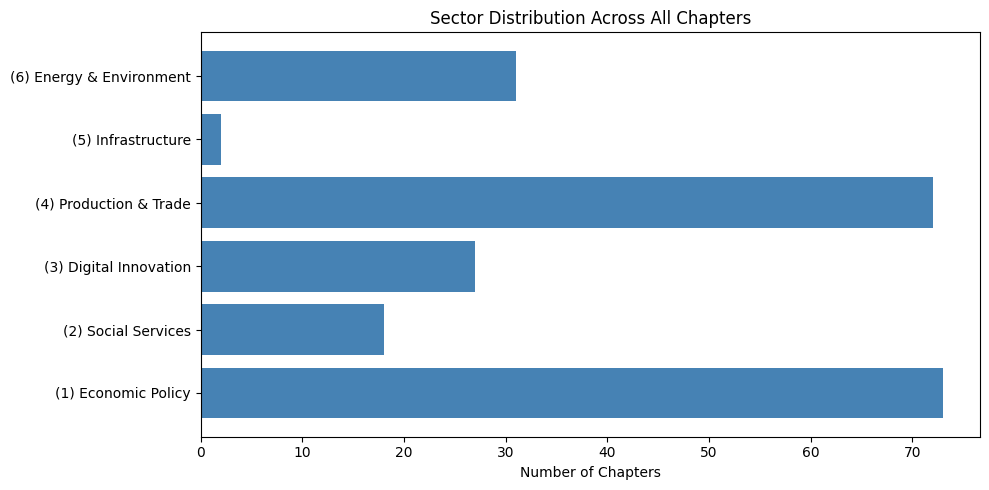

Saved sector_distribution.png


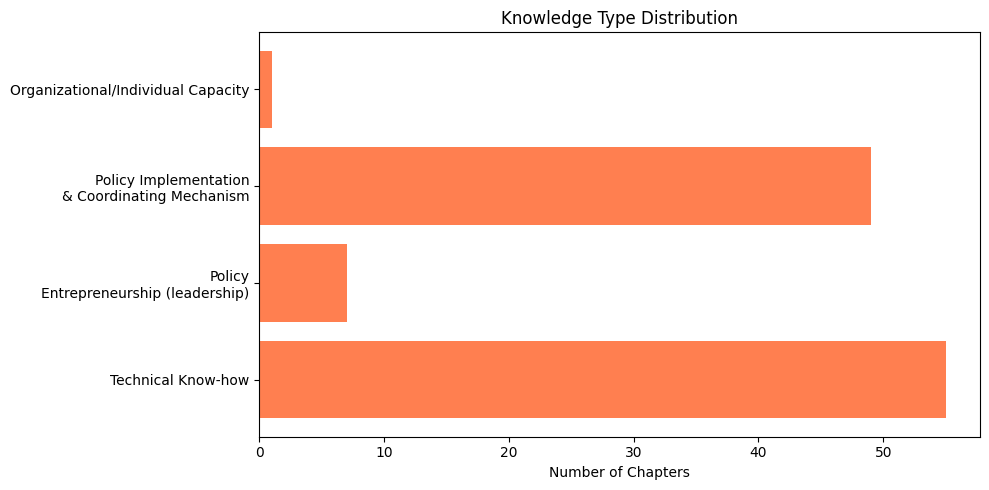

Saved knowledge_type_distribution.png


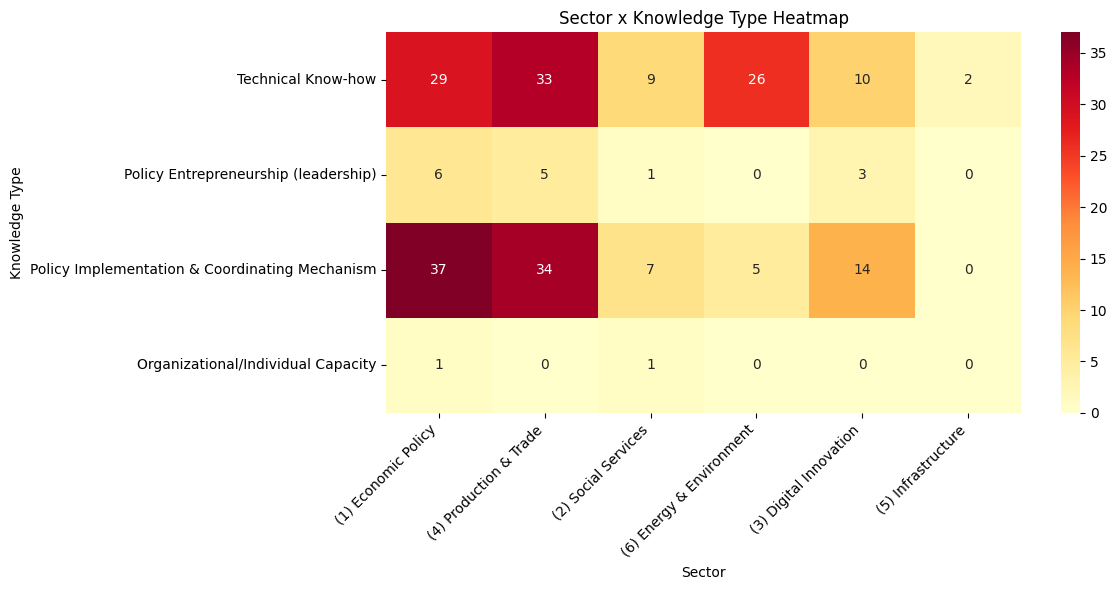

Saved sector_knowledge_heatmap.png

PER-REPORT SUMMARY

--- 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E ---
  Chapters analyzed: 52
  Korean policies extracted: 77
  Top sectors: ['(1) Economic Policy(55), (4) Production & Trade(19), (3) Digital Innovation(10)']
  Knowledge types: {'Technical Know-how': 21, 'Policy Entrepreneurship (leadership)': 3, 'Policy Implementation & Coordinating Mechanism': 27, 'Organizational/Individual Capacity': 1}
  Policies:
    - CAEL Rating System for Financial Institutions (None)
    - Korean Credit Union Movement (1960)
    - CAEL Rating System (None)
    - Financial Industry Early Warning System (FIEWS) (2007)
    - Risk Evaluation and Forecasting System (Refs) (2009)
    - Korean Capital Account Liberalization Strategy (None)
    - M2 Targeting Monetary Policy Rule (1980)
    - Zero Base Budget Planning (None)
    - Government Managed Funds Reform (None)
    - Balanced Budget Policy (None)
    - Mo

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter


def visualize_results(results: List[Dict]):
    """Generate visualizations from chapter analysis results."""

    # Filter out errors
    valid = [r for r in results if 'taxonomy_classification' in r]
    print(f'Visualizing {len(valid)} successfully analyzed chapters ({len(results) - len(valid)} errors)\n')

    if not valid:
        print('No valid results to visualize')
        return

    # --- 1. Sector Distribution ---
    sector_counts = Counter()
    for r in valid:
        for s in r['taxonomy_classification'].get('sectors', []):
            sector_counts[s['sector']] += 1

    if sector_counts:
        fig, ax = plt.subplots(figsize=(10, 5))
        sectors = sorted(sector_counts.keys())
        counts = [sector_counts[s] for s in sectors]
        # Wrap long sector names
        labels = [s.replace('&', '&\n') if len(s) > 25 else s for s in sectors]
        ax.barh(labels, counts, color='steelblue')
        ax.set_xlabel('Number of Chapters')
        ax.set_title('Sector Distribution Across All Chapters')
        plt.tight_layout()
        plt.savefig(f'{config.results_dir}/sector_distribution.png', dpi=150, bbox_inches='tight')
        plt.show()
        print('Saved sector_distribution.png')

    # --- 2. Knowledge Type Distribution ---
    kt_counts = Counter()
    for r in valid:
        kt = r['taxonomy_classification'].get('knowledge_type', 'Unknown')
        kt_counts[kt] += 1

    if kt_counts:
        fig, ax = plt.subplots(figsize=(10, 5))
        kt_labels = list(kt_counts.keys())
        kt_vals = [kt_counts[k] for k in kt_labels]
        # Wrap long labels
        wrapped_labels = []
        for label in kt_labels:
            if len(label) > 35:
                words = label.split()
                mid = len(words) // 2
                wrapped_labels.append(' '.join(words[:mid]) + '\n' + ' '.join(words[mid:]))
            else:
                wrapped_labels.append(label)
        ax.barh(wrapped_labels, kt_vals, color='coral')
        ax.set_xlabel('Number of Chapters')
        ax.set_title('Knowledge Type Distribution')
        plt.tight_layout()
        plt.savefig(f'{config.results_dir}/knowledge_type_distribution.png', dpi=150, bbox_inches='tight')
        plt.show()
        print('Saved knowledge_type_distribution.png')

    # --- 3. Sector x Knowledge Type Heatmap ---
    if sector_counts and kt_counts:
        cross_data = defaultdict(lambda: defaultdict(int))
        for r in valid:
            kt = r['taxonomy_classification'].get('knowledge_type', 'Unknown')
            for s in r['taxonomy_classification'].get('sectors', []):
                cross_data[s['sector']][kt] += 1

        df_cross = pd.DataFrame(cross_data).fillna(0).astype(int)
        if not df_cross.empty:
            fig, ax = plt.subplots(figsize=(12, 6))
            sns.heatmap(df_cross, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
            ax.set_title('Sector x Knowledge Type Heatmap')
            ax.set_ylabel('Knowledge Type')
            ax.set_xlabel('Sector')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(f'{config.results_dir}/sector_knowledge_heatmap.png', dpi=150, bbox_inches='tight')
            plt.show()
            print('Saved sector_knowledge_heatmap.png')

    # --- 4. Per-Report Summary ---
    print('\n' + '='*60)
    print('PER-REPORT SUMMARY')
    print('='*60)

    report_groups = defaultdict(list)
    for r in valid:
        report_groups[r['report_id']].append(r)

    for report_id, chapters in report_groups.items():
        print(f'\n--- {report_id} ---')
        print(f'  Chapters analyzed: {len(chapters)}')

        # Policies
        total_policies = 0
        for ch in chapters:
            policies = ch.get('korean_policies', 'Not Applicable')
            if isinstance(policies, list):
                total_policies += len(policies)
        print(f'  Korean policies extracted: {total_policies}')

        # Top sectors
        ch_sectors = Counter()
        for ch in chapters:
            for s in ch['taxonomy_classification'].get('sectors', []):
                ch_sectors[s['sector']] += 1
        if ch_sectors:
            top = ch_sectors.most_common(3)
            print(f'  Top sectors: {[", ".join(f"{s}({c})" for s, c in top)]}')

        # Knowledge types
        ch_kt = Counter(ch['taxonomy_classification'].get('knowledge_type', 'Unknown') for ch in chapters)
        print(f'  Knowledge types: {dict(ch_kt)}')

        # Show policies
        if total_policies > 0:
            print(f'  Policies:')
            for ch in chapters:
                policies = ch.get('korean_policies', 'Not Applicable')
                if isinstance(policies, list):
                    for p in policies:
                        yr = p.get('year_initiated', '?')
                        print(f'    - {p["policy_name"]} ({yr})')


# Run visualization
if 'analysis_results' in locals() and analysis_results:
    visualize_results(analysis_results)
else:
    # Try loading from file
    results_path = f'{config.results_dir}/chapter_analysis.json'
    if os.path.exists(results_path):
        with open(results_path) as f:
            analysis_results = json.load(f)
        print(f'Loaded {len(analysis_results)} results from file')
        visualize_results(analysis_results)
    else:
        print('No analysis results found. Run Section 8 first.')


DETAILED VIEW: 2023_QAT_Climate Smart Agriculture and Indoor Farming in Qatar

  [L1] 1. Project Background and Objectives
    Pages 15-18 | 3524 chars
    Sector: (4) Production & Trade > Agriculture, Forestry & Fisheries > Agricultural Development
    Keywords: Sustainable Agriculture, Agricultural Policy & Administration
    Sector: (6) Energy & Environment > Climate Change > Climate Change Adaptation
    Keywords: Climate Adaptation Strategies
    Sector: (2) Social Services > Cross-Cutting Social Issues > Gender Equality & Empowerment
    Keywords: Food Security & Nutrition
    Knowledge type: Technical Know-how
    Confidence: high
    Policy: Korea's Smart Agricultural Technology (None) [Agriculture and Climate Change Adaptation]
      Org: None
      Challenge: Climate-smart agriculture and indoor farming solutions for countries with adverse agricultural conditions
      Instruments: Technology transfer, Knowledge sharing through KSP
      Evidence: "Qatar has applied for the 

/tmp/ipython-input-622796242.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


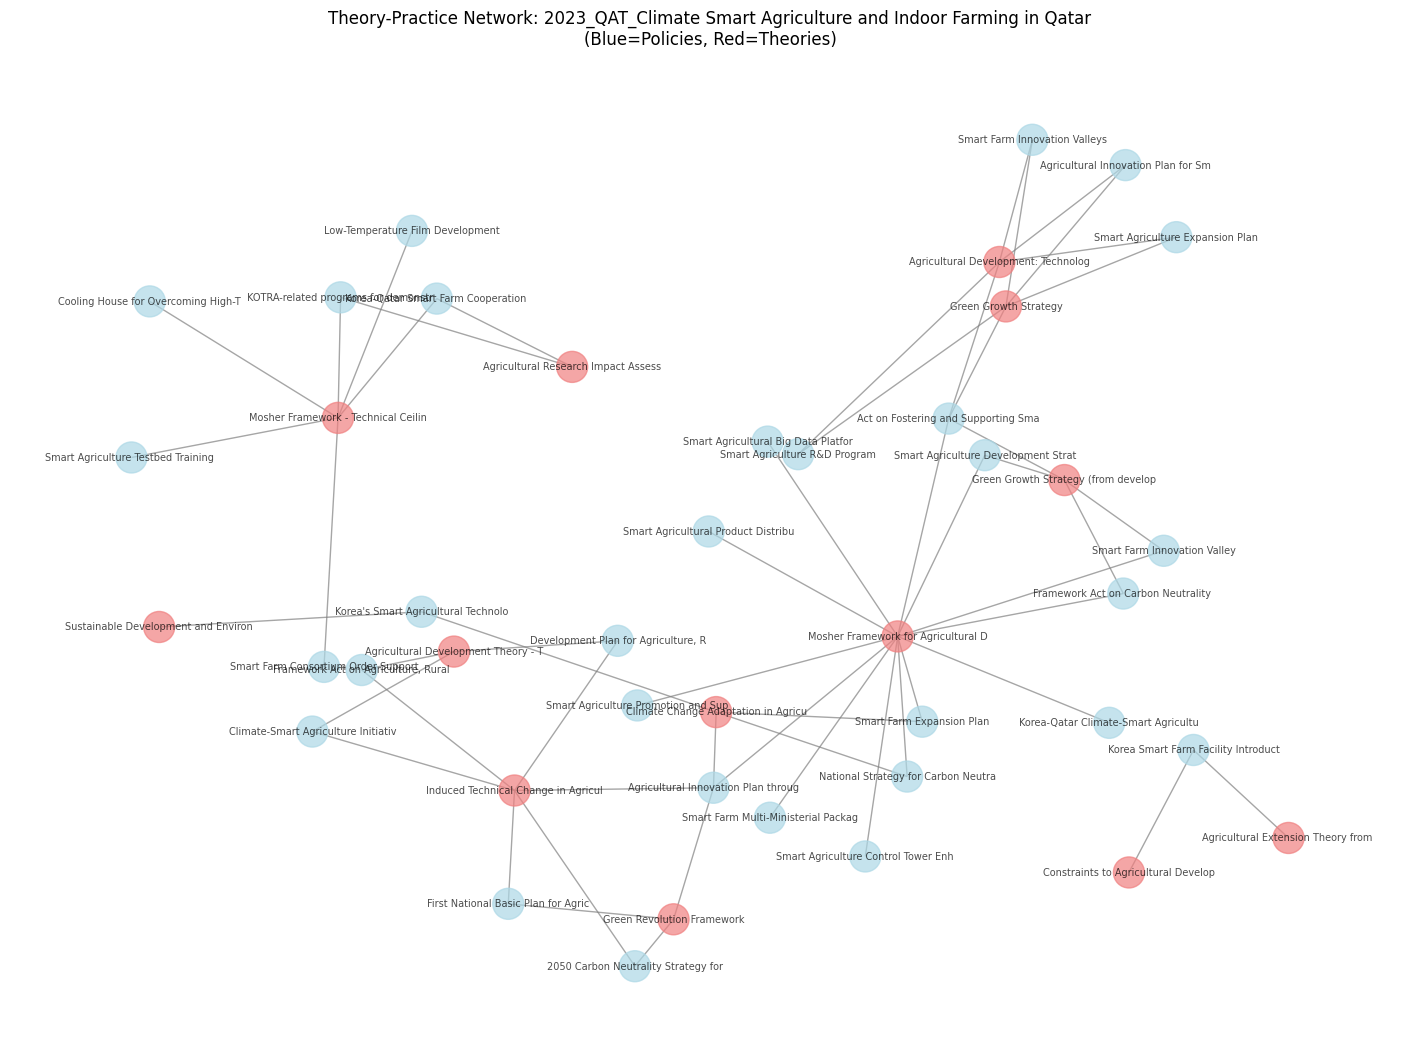


DETAILED VIEW: 2014_SLV_Developing an Innovation Ecosystem... Plastics Pharmaceutical and Cosmetics and Textile Industries

  [L1] 2014/15 KSP with El Salvador
    Pages 15-18 | 8056 chars
    Sector: (1) Economic Policy > Investment & Private Sector Dev. > Private Sector Support
    Keywords: Small & Medium Enterprise (SME) Dev., Private Sector Support
    Sector: (4) Production & Trade > Industry & Services > Industrial Development
    Keywords: Industrial Policy, Manufacturing
    Knowledge type: Policy Implementation & Coordinating Mechanism
    Confidence: high
    Policy: Korea Institute of Industrial Technology (KITECH) Model (None) [Industrial Development]
      Org: KITECH
      Challenge: Supporting industrial innovation and technology development through specialized research institutes
      Instruments: Industrial research institutes, Technology transfer, Industry-research collaboration
      Evidence: "They were specifically interested in the role of KITECH, as it is the 

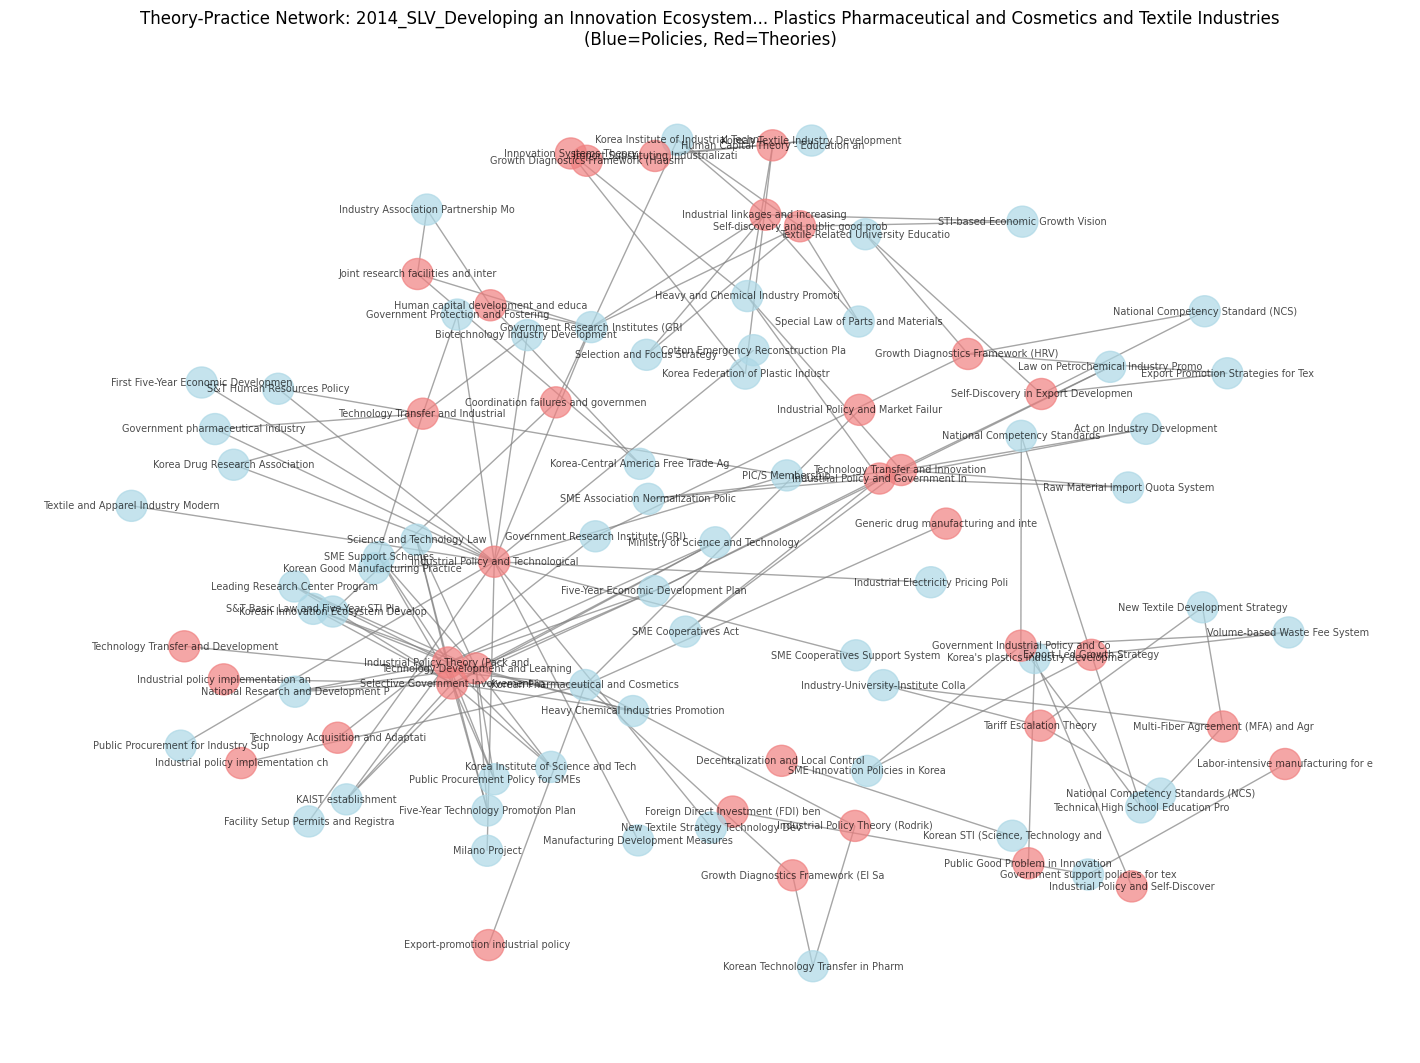


DETAILED VIEW: 2023_KAZ_Project on Extending the Life of Old Power Plants and Improving Energy Efficiency of Aging Power Plants in Kazakhstan

  [L1] A. Background of the Project
    Pages 13-15 | 5856 chars
    Sector: (6) Energy & Environment > Climate Change > Climate Change Mitigation
    Keywords: Energy Efficiency, Greenhouse Gas (GHG) Reduction
    Sector: (6) Energy & Environment > Energy > Energy Generation & Supply
    Keywords: Non-Renewable Energy (Fossil Fuels), Energy Transmission & Distribution
    Knowledge type: Technical Know-how
    Confidence: high
    Korean policies: Not Applicable
    Theory: Geography and economic development theory (Gallup, Sachs, and Mellinger) - Kazakhstan's vast land area and natural resources have contributed to its econom
    Theory: Climate change and development challenges (Intergovernmental Panel on Climate Change) - Kazakhstan faces the dual challenge of maintaining economic growth while meeting

  [L1] B. Project Execution
    Pages 

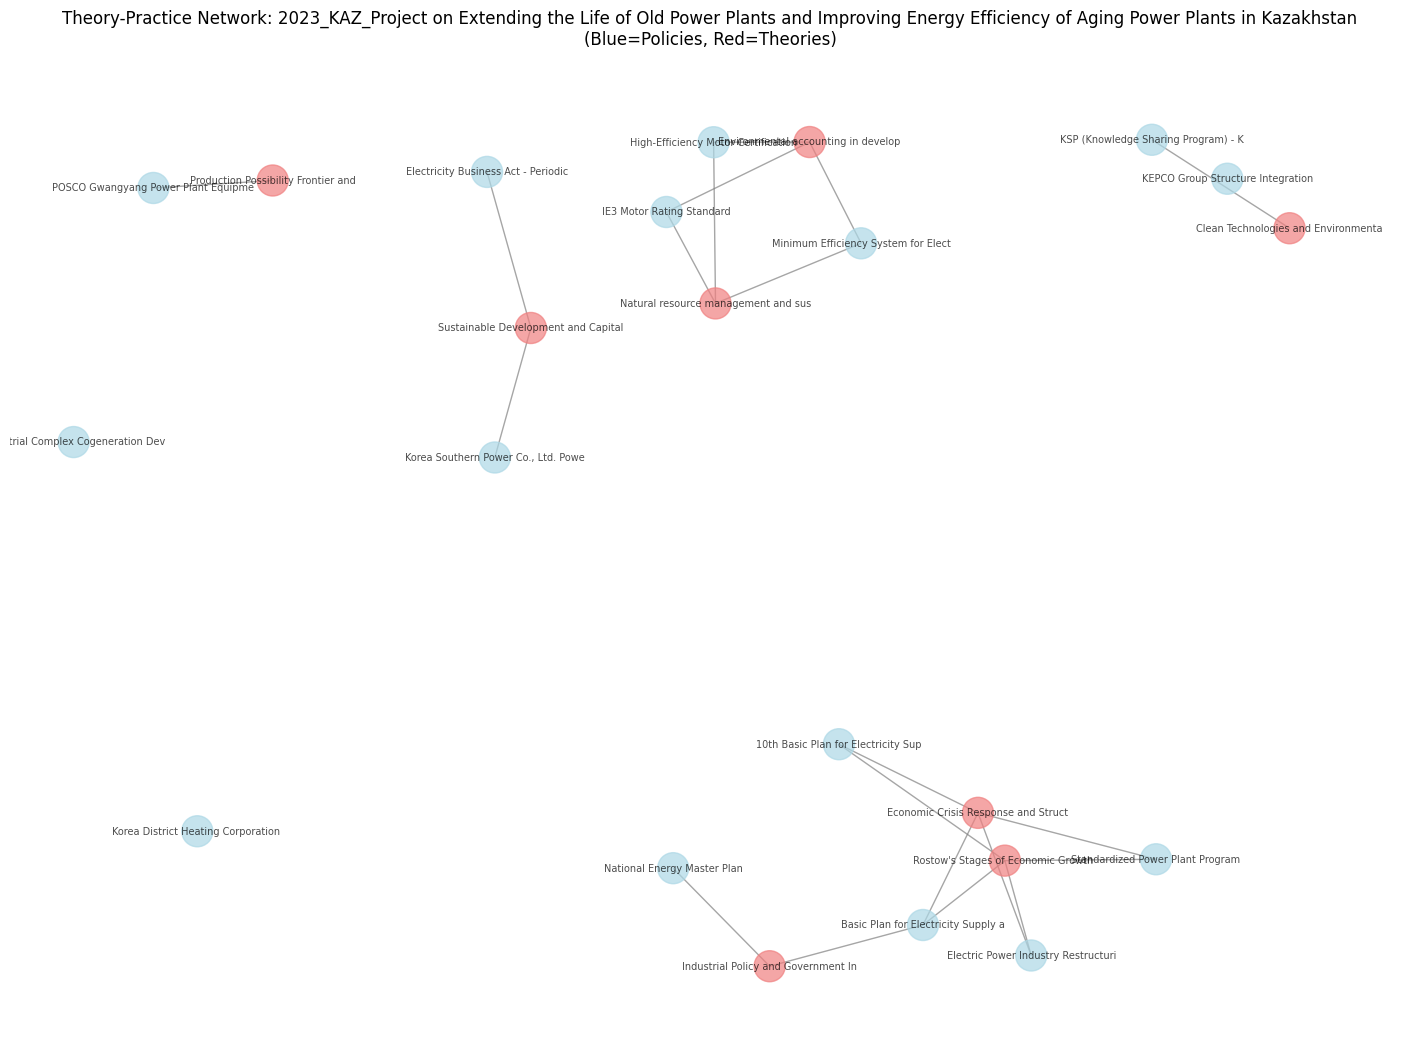


DETAILED VIEW: 2009_VNM_Supporting the Establishment of Vietnam’s 2011-20 Socio-economic Development Strategy_E

  [L1] 1. Assessment of Vietnam’s Economic Growth Performance
    Pages 31-31 | 1530 chars
    Sector: (1) Economic Policy > Inclusive & Sustainable Growth > Growth Diagnostics & Strategy
    Keywords: Economic Growth Strategy, Structural Reform, Productivity Analysis
    Knowledge type: Technical Know-how
    Confidence: high
    Korean policies: Not Applicable
    Theory: Growth accounting and cross-country growth comparison methodologies - The chapter explicitly mentions using 'cross country comparison of growth accoun
    Theory: Institutional development for sustained growth (Rodrik, 2005) - The chapter directly references Rodrik's work on the importance of developing an

  [L1] 2. Projection of GDP Growth
    Pages 32-33 | 4046 chars
    Sector: (1) Economic Policy > Inclusive & Sustainable Growth > Growth Diagnostics & Strategy
    Keywords: Economic Growth Strategy,

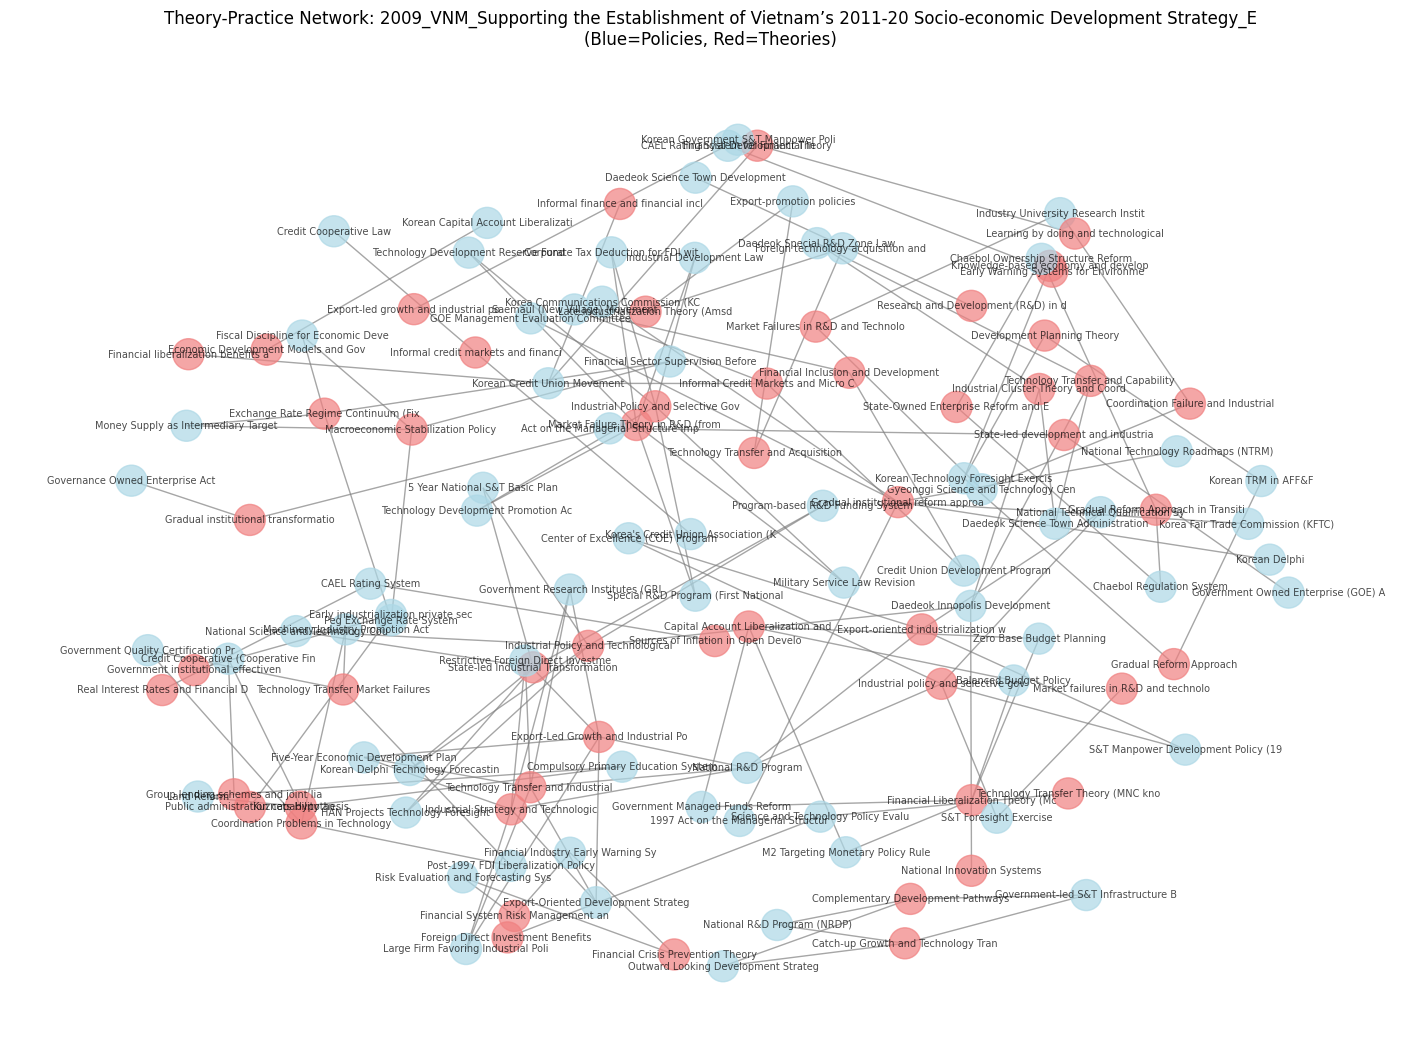

In [17]:
# Detailed chapter-level view for one report
import networkx as nx


def show_detailed_report(results: List[Dict], report_id: str = None):
    """Show detailed chapter-by-chapter view for a specific report."""

    valid = [r for r in results if 'taxonomy_classification' in r]
    if report_id:
        report_chapters = [r for r in valid if r['report_id'] == report_id]
    else:
        # Show first report
        if not valid:
            print('No valid results')
            return
        report_id = valid[0]['report_id']
        report_chapters = [r for r in valid if r['report_id'] == report_id]

    print(f'\nDETAILED VIEW: {report_id}')
    print('='*80)

    for ch in report_chapters:
        indent = '  ' * ch.get('chapter_level', 0)
        print(f'\n{indent}[L{ch.get("chapter_level", 0)}] {ch["chapter_title"]}')
        print(f'{indent}  Pages {ch["page_start"]}-{ch["page_end"]} | {ch["content_length"]} chars')

        tc = ch['taxonomy_classification']
        for s in tc.get('sectors', []):
            kws = ', '.join(s.get('keywords', []))
            print(f'{indent}  Sector: {s["sector"]} > {s.get("sub_sector_l1", "")} > {s.get("sub_sector_l2", "")}')
            print(f'{indent}  Keywords: {kws}')
        print(f'{indent}  Knowledge type: {tc.get("knowledge_type", "N/A")}')
        print(f'{indent}  Confidence: {tc.get("confidence", "N/A")}')

        policies = ch.get('korean_policies', 'Not Applicable')
        if isinstance(policies, list) and policies:
            for p in policies:
                print(f'{indent}  Policy: {p["policy_name"]} ({p.get("year_initiated", "?")}) [{p.get("sector", "")}]')
                print(f'{indent}    Org: {p.get("organization", "N/A")}')
                print(f'{indent}    Challenge: {p.get("challenge_addressed", "N/A")}')
                instruments = p.get('policy_instruments', [])
                if instruments:
                    print(f'{indent}    Instruments: {", ".join(instruments)}')
                quote = p.get('evidence_quote', '')
                if quote:
                    print(f'{indent}    Evidence: "{quote[:100]}..."')
        elif policies == 'Not Applicable':
            print(f'{indent}  Korean policies: Not Applicable')

        theories = ch.get('related_theories', 'Not Applicable')
        if isinstance(theories, list) and theories:
            for t in theories:
                print(f'{indent}  Theory: {t.get("theory", "")} - {t.get("relevance", "")[:80]}')
        elif theories == 'Not Applicable':
            print(f'{indent}  Related theories: Not Applicable')

    # Theory-Practice Network for this report
    policies_for_network = []
    for ch in report_chapters:
        policies = ch.get('korean_policies', 'Not Applicable')
        theories = ch.get('related_theories', 'Not Applicable')
        if isinstance(policies, list):
            for p in policies:
                p_theories = theories if isinstance(theories, list) else []
                policies_for_network.append((p, p_theories))

    if policies_for_network:
        G = nx.Graph()
        for policy, theories in policies_for_network:
            pname = policy['policy_name'][:35]
            G.add_node(pname, node_type='policy')
            for t in theories:
                tname = t.get('theory', '')[:35]
                if tname:
                    G.add_node(tname, node_type='theory')
                    G.add_edge(pname, tname)

        if G.number_of_nodes() > 0:
            plt.figure(figsize=(14, 10))
            pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
            colors = ['lightblue' if G.nodes[n].get('node_type') == 'policy' else 'lightcoral' for n in G.nodes()]
            nx.draw(G, pos, node_color=colors, with_labels=True, font_size=7,
                    node_size=500, alpha=0.7, edge_color='gray')
            plt.title(f'Theory-Practice Network: {report_id}\n(Blue=Policies, Red=Theories)')
            plt.tight_layout()
            safe_name = report_id.replace(' ', '_')[:50]
            plt.savefig(f'{config.results_dir}/network_{safe_name}.png', dpi=150, bbox_inches='tight')
            plt.show()


# Show detailed view for each report
if 'analysis_results' in locals() and analysis_results:
    report_ids = list(set(r['report_id'] for r in analysis_results if 'taxonomy_classification' in r))
    for rid in report_ids:
        show_detailed_report(analysis_results, rid)

## Section 10: Summary & Next Steps

In [18]:
print('\n' + '='*60)
print('CHAPTER-LEVEL ANALYSIS COMPLETE')
print('='*60)

print(f'\nResults saved in: {config.project_dir}')
print('\nKey outputs:')
print(f'  1. Chapter summaries: {config.processed_dir}/chapter_summaries.json')
print(f'  2. Full analysis: {config.results_dir}/chapter_analysis.json')
print(f'  3. Visualizations: {config.results_dir}/*.png')
print(f'  4. Textbook vectors: {config.vector_db_dir}/')

# Load and display summary stats
if 'analysis_results' in locals() and analysis_results:
    valid = [r for r in analysis_results if 'taxonomy_classification' in r]
    errors = len(analysis_results) - len(valid)

    total_policies = sum(
        len(r['korean_policies'])
        for r in valid
        if isinstance(r.get('korean_policies'), list)
    )

    chapters_with_policies = sum(
        1 for r in valid
        if isinstance(r.get('korean_policies'), list) and len(r['korean_policies']) > 0
    )

    chapters_with_theories = sum(
        1 for r in valid
        if isinstance(r.get('related_theories'), list) and len(r['related_theories']) > 0
    )

    print(f'\nSummary Statistics:')
    print(f'  Reports processed: {len(set(r["report_id"] for r in analysis_results))}')
    print(f'  Chapters analyzed: {len(valid)} ({errors} errors)')
    print(f'  Korean policies extracted: {total_policies} (in {chapters_with_policies} chapters)')
    print(f'  Chapters with theory links: {chapters_with_theories}')

    # Sector coverage
    all_sectors = Counter()
    for r in valid:
        for s in r['taxonomy_classification'].get('sectors', []):
            all_sectors[s['sector']] += 1
    print(f'  Sector coverage: {len(all_sectors)} sectors used')
    for sector, count in all_sectors.most_common():
        print(f'    {sector}: {count} chapters')

print('\nNext steps:')
print('  1. Review chapter_analysis.json for quality')
print('  2. Check taxonomy classification accuracy')
print('  3. Verify Korean policy extraction completeness')
print('  4. Scale to full 566 KSP reports if quality is satisfactory')

print('\n' + '='*60)


CHAPTER-LEVEL ANALYSIS COMPLETE

Results saved in: /content/drive/MyDrive/KM4D_v0

Key outputs:
  1. Chapter summaries: /content/drive/MyDrive/KM4D_v0/data/processed/chapter_summaries.json
  2. Full analysis: /content/drive/MyDrive/KM4D_v0/data/results/chapter_analysis.json
  3. Visualizations: /content/drive/MyDrive/KM4D_v0/data/results/*.png
  4. Textbook vectors: /content/drive/MyDrive/KM4D_v0/vector_db/

Summary Statistics:
  Reports processed: 4
  Chapters analyzed: 112 (0 errors)
  Korean policies extracted: 194 (in 75 chapters)
  Chapters with theory links: 108
  Sector coverage: 6 sectors used
    (1) Economic Policy: 73 chapters
    (4) Production & Trade: 72 chapters
    (6) Energy & Environment: 31 chapters
    (3) Digital Innovation: 27 chapters
    (2) Social Services: 18 chapters
    (5) Infrastructure: 2 chapters

Next steps:
  1. Review chapter_analysis.json for quality
  2. Check taxonomy classification accuracy
  3. Verify Korean policy extraction completeness
  4. S